In [11]:
import re
import numpy as np
from sklearn.metrics import roc_auc_score
import fasttext
import pandas as pd
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [8]:
model = fasttext.train_supervised(
    'data/fasttext_processed_data_train_balanced.txt',
    minn=3,
    minCount=100,
)

In [27]:
len(list(set(model.words)))

21609

In [9]:
test_data = open('data/fasttext_processed_data_test_unbalanced.txt').read().split('\n')[:-1]
test_data, y_true = list(zip(*list(map(lambda x: tuple(x.split('__label__')), test_data))))
test_data = list(test_data)
y_true = [int(x) for x in y_true]

In [ ]:
y_pred, y_prob = model.predict(test_data)
y_pred = np.array(y_pred).ravel()
y_pred = list(map(lambda x: int(x.replace('__label__', '')), y_pred))
y_prob = y_prob.ravel()
y_prob = list(map(lambda x: x[1] if x[0] == 1 else 1 - x[1], zip(y_pred, y_prob)))

Fast text AUC

In [14]:
roc_auc_score(y_true, y_prob)

0.8806910607906715

True ratio 1s/0s

In [23]:
pd.Series(y_true).value_counts()

0    246089
1     11379
dtype: int64

Predicted ratio 1s/0s

In [24]:
pd.Series(y_pred).value_counts()

0    184508
1     72960
dtype: int64

In [15]:
test_df = pd.concat([
    pd.Series(test_data).to_frame('X'),
    pd.Series(y_true).to_frame('y')
], axis=1)

In [16]:
temp_sample = test_df.sample(500)

In [19]:
words_0 = temp_sample.loc[lambda s: s['y']==0]['X'].str.split(expand=True).unstack().dropna().unique()
words_1 = temp_sample.loc[lambda s: s['y']==1]['X'].str.split(expand=True).unstack().dropna().unique()

words_0_unique = pd.Series(words_0).loc[lambda s: ~s.isin(words_1)]
words_1_unique = pd.Series(words_1).loc[lambda s: ~s.isin(words_0)]

words_0_in_model = words_0_unique.loc[lambda s: s.apply(lambda x: x in model)]
words_1_in_model = words_1_unique.loc[lambda s: s.apply(lambda x: x in model)]

words_1_sample = words_1_in_model.sample(10)
words_1_embedding = [model[w] for w in words_1_sample]
words_1_embedding = np.array(words_1_embedding)

words_0_sample = words_0_in_model.sample(10)
words_0_embedding = [model[w] for w in words_0_sample]
words_0_embedding = np.array(words_0_embedding)

In [20]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(np.vstack((words_0_embedding, words_1_embedding)))

fast text embeddings

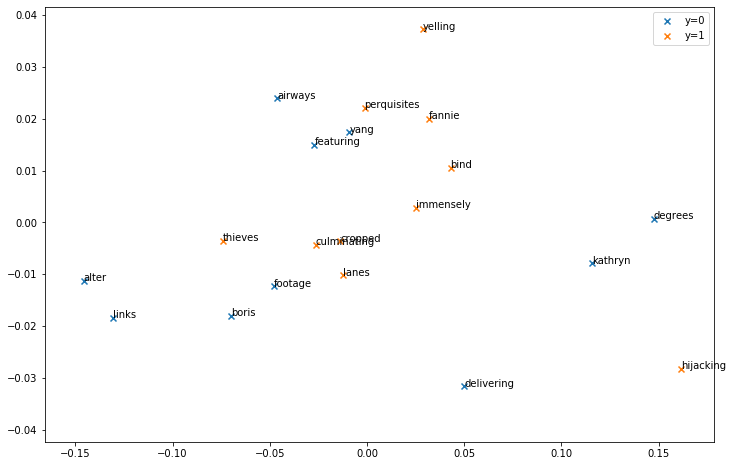

In [21]:
plt.figure(figsize=(12, 8))
plt.scatter(emb_2d[:10, 0], emb_2d[:10, 1], marker='x', label='y=0')
for idx, word in enumerate(words_0_sample):
    plt.text(emb_2d[idx, 0], emb_2d[idx, 1], word)
    
plt.scatter(emb_2d[10:, 0], emb_2d[10:, 1], marker='x', label='y=1')
for idx, word in enumerate(words_1_sample):
    plt.text(emb_2d[idx+10, 0], emb_2d[idx+10, 1], word)
    
plt.legend()